# Jupyter Example 3 for HERMES: Spectrum of Inverse Compton

In [1]:
from pyhermes import *
from pyhermes.units import *

import astropy.units as u
import astropy.constants as uc

import numpy as np
import healpy
import matplotlib.pyplot as plt

Let's first plot spectra of CMB and the built-in ISRF model (Vernetto & Lipar, 2016, arxiv:1608.01587)

In [2]:
photonfields = {
    'CMB': CMB(),
    'ISRF (VL16)': ISRF()
}

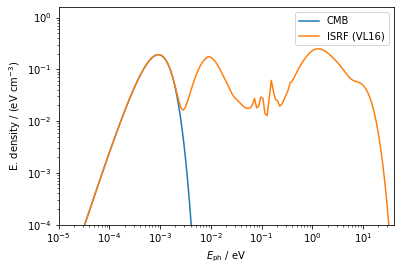

In [3]:
sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)

for name, field in photonfields.items():
    energies = np.array(field.getEnergyAxis()) # one can go more dense than this if needed, see doc/source
    energyDensities = np.array(
        [field.getEnergyDensity(sun_pos, E) for E in energies])
    plt.loglog(energies/eV, energyDensities/eV*cm3, '-', label=name)

plt.xlabel(r'$E_\mathrm{ph}$ / eV')
plt.ylabel(r'E. density / (eV $\mathrm{cm}^{-3}$)')
plt.ylim(10**(-4), 10**(0.2))
plt.xlim(10**(-5), 10**1.6)
plt.legend()

In [4]:
nside = 128 # in general, for IC, it is not needed more than 128

In [5]:
dragon2D_leptons = Dragon2DCRDensity([Electron, Positron])
kleinnishina = KleinNishina()

In [6]:
mask_edges = ([5*deg, 0*deg], [-5*deg, 180*deg]) # the Galactic disc (the other half is not needed due to symmetry of components)
mask = RectangularWindow(*mask_edges)

In [7]:
def calc_skymaps(field):
    
    integrator = InverseComptonIntegrator(dragon2D_leptons, field, kleinnishina)
    integrator.setSunPosition(sun_pos)
    integrator.setupCacheTable(30, 30, 6) # we are interested only in a crude calculation;
                                          # longer calculations we save for later examples (python scripts)
    
    skymap_range = GammaSkymapRange(nside, 1*GeV, 100*TeV, 30) # this prepares a range of GammaSkymaps
    skymap_range.setIntegrator(integrator)
    skymap_range.setMask(mask)
    
    skymap_range.compute() # it takes ~2 min on a 4-core laptop
    
    return skymap_range

In [8]:
skymap_range_CMB = calc_skymaps(photonfields['CMB'])

In [9]:
skymap_range_ISRF = calc_skymaps(photonfields['ISRF (VL16)'])

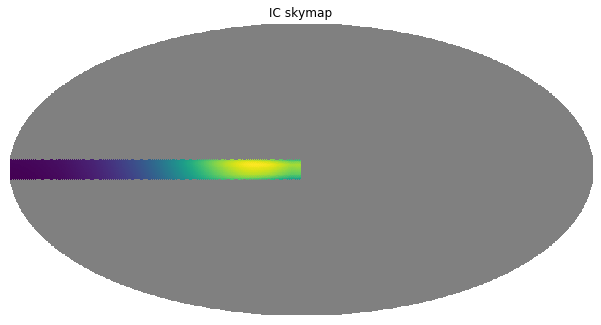

In [10]:
healpy.mollview(np.array(skymap_range_CMB[0]), title="IC skymap", unit=None, cbar=None) # to plot the first skymap of CMB, just to check how does it look like

In [11]:
use_units = skymap_range_CMB[0].getUnits() # default units for GammaSkymap (GeV^-1 m^-2 s^-1 sr^-1)
use_units = "GeV^-1 cm^-2 s^-1 sr^-1" # override default
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

In [12]:
def calc_mean_flux(skymap_range):
    energies = np.array([float(s.getEnergy()/GeV) for s in skymap_range])
    fluxes = np.array([s.getMean() for s in skymap_range]) / base_units
    return energies, fluxes

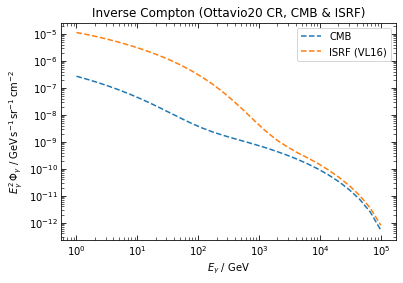

In [13]:
def plot_spectrum(skymap_range, label):
    energies, fluxes = calc_mean_flux(skymap_range)
    
    plt.plot(energies, fluxes*energies**2, '--', label=label)
    plt.xlabel("$E_\gamma$ / GeV")
    plt.ylabel("$E_\gamma^2\, \Phi_\gamma$ / " + (skymap_units*u.GeV**2).unit.to_string(format='latex_inline'))

fig, ax = plt.subplots()

plot_spectrum(skymap_range_CMB, 'CMB')
plot_spectrum(skymap_range_ISRF, 'ISRF (VL16)')

plt.title("Inverse Compton (Ottavio20 CR, CMB & ISRF)")
plt.legend()

ax.tick_params(which='minor', direction='in', axis='both', bottom='on', top='on', left='on', right='on', length=3)
ax.tick_params(which='major', direction='in', axis='both', bottom='on', top='on', left='on', right='on', length=5)
plt.xscale("log")
plt.yscale("log")

#plt.savefig("spectrum-180-ISRF-CMB-Dragon2D.pdf", dpi=150)